# Silent Signals Dataset - Combined Data Report

Lino Zurmühl

## 1. Introduction
This notebook provides a data report on the combined data from the Silent Signals dataset. 
- Data inspection and label distribution.
- Key observations regarding root words in the dogwhistle class.
- The impact of manual label review on dataset quality.

## 2. Data Import and Preprocessing

In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

dataset = load_dataset("SALT-NLP/silent_signals")
print(dataset)

dataset = dataset["train"]
# as pandas dataframe

df = pd.DataFrame(dataset)

# function that drops duplicates but saves those dropped instances in a separate data frame
def drop_duplicates_save(df):
    duplicates = df[df.duplicated(subset=["content"], keep=False)]
    df = df.drop_duplicates(subset=["content"])
    # drop missing values in lable and content
    df = df.dropna(subset=["content"])
    if "lable" in df.columns:
        df = df.dropna(subset=["lable"])
    return df, duplicates

/Users/linozurmuhl/miniforge3/envs/NLP/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MPS is available on this device
DatasetDict({
    train: Dataset({
        features: ['dog_whistle', 'dog_whistle_root', 'ingroup', 'content', 'date', 'speaker', 'chamber', 'subreddit', 'source', 'definition', 'type', 'party'],
        num_rows: 16258
    })
})


In [2]:
# filter out the informal and formal sentences
df_informal = df[df["type"] == "Informal"]
df_formal = df[df["type"] == "Formal"]
print('With duplicates:', df_informal.shape, df_formal.shape)
# drop duplicates
df_informal, duplicates_if_1 = drop_duplicates_save(df_informal)
df_formal, duplicates_f_1 = drop_duplicates_save(df_formal)
print('Without duplicates:', df_informal.shape, df_formal.shape)

With duplicates: (12923, 12) (3335, 12)
Without duplicates: (12901, 12) (3298, 12)


In [3]:
# load csv 0 Instances
null_dataset_formal = pd.read_csv("0_data/formal_neg_predictions.csv")
null_dataset_informal = pd.read_csv("0_data/informal_neg_predictions.csv")

/var/folders/vx/1wqkklmd4qzbv02gbc6344wc0000gn/T/ipykernel_61961/3542576506.py:2: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  null_dataset_formal = pd.read_csv("0_data/formal_neg_predictions.csv")


In [10]:
# join null informal data and original informal data
df_informal = pd.concat([df_informal, null_dataset_informal])

# label missing values as 1 in label column
df_informal['lable'] = df_informal['lable'].fillna(1)

# join null formal data and original formal data
df_formal = pd.concat([df_formal, null_dataset_formal])

# label missing values as 0 in label column
df_formal['lable'] = df_formal['lable'].fillna(1)

# drop duplicates
df_informal, duplicates_if_2 = drop_duplicates_save(df_informal)

## 3. Exploratory Data Analysis

### 3.1 Label Distribution of Combined Data

We have 14 columns of which the label and content columns are the most important for our analysis. The label column contains the target variable and the content contains the text data from reddit. The target variable is a binary variable with 0 representing the dogwhistle class and 1 representing the non-dogwhistle class.

We have 47,111 rows in the dataset. The dataset is imbalanced with 27.38% in the dogwhistle class and 72.62% in the non-dogwhistle class.

In [11]:
print(df_informal.info())

<class 'pandas.core.frame.DataFrame'>
Index: 47111 entries, 0 to 34359
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dog_whistle       47111 non-null  object 
 1   dog_whistle_root  47111 non-null  object 
 2   ingroup           47111 non-null  object 
 3   content           47111 non-null  object 
 4   date              47111 non-null  object 
 5   speaker           0 non-null      object 
 6   chamber           0 non-null      object 
 7   subreddit         47095 non-null  object 
 8   source            47095 non-null  object 
 9   definition        47111 non-null  object 
 10  type              47111 non-null  object 
 11  party             0 non-null      object 
 12  community         16 non-null     object 
 13  in_group          34194 non-null  object 
 14  lable             47111 non-null  float64
dtypes: float64(1), object(14)
memory usage: 5.8+ MB
None


/var/folders/vx/1wqkklmd4qzbv02gbc6344wc0000gn/T/ipykernel_61961/3980190155.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='lable', data=df_informal, palette='Set2')


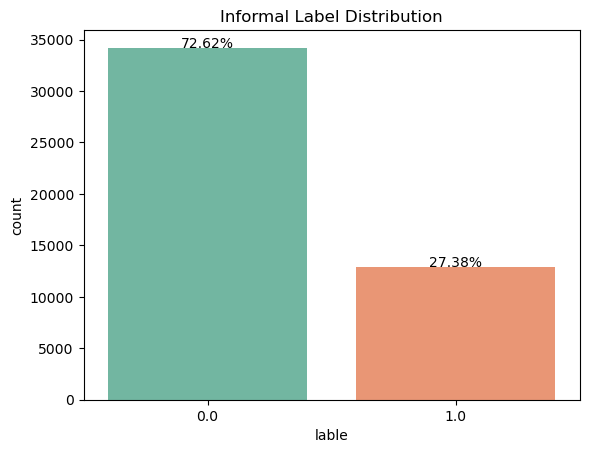

In [29]:
ax = sns.countplot(x='lable', data=df_informal, palette='Set2')
# add percentage of each class
total = len(df_informal)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 3, f'{height/total:.2%}', ha="center")

plt.title('Informal Label Distribution')
plt.show()

**Key Observation:** 
This class imbalance will need to be addressed during model training with techniques like SMOTE or class weights.


### 3.2 Dogwhistle Root Analysis

/var/folders/vx/1wqkklmd4qzbv02gbc6344wc0000gn/T/ipykernel_61961/2523524849.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=informal_dogwhistle_roots.values,


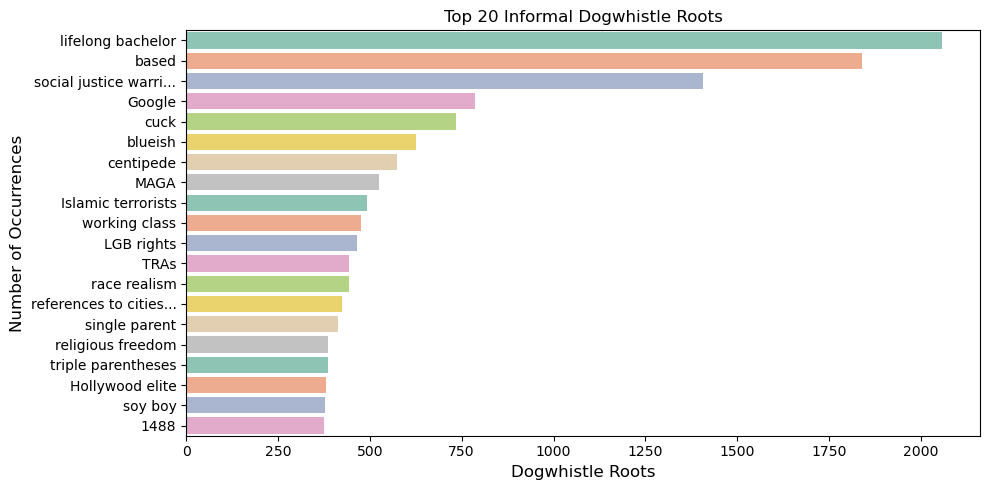

In [28]:
 # Count informal dogwhilste_roots and plot top 20
informal_dogwhistle_roots = df_informal['dog_whistle_root'].value_counts()
informal_dogwhistle_roots = informal_dogwhistle_roots[:20].sort_values(ascending=False)

# Truncate long labels
MAX_LENGTH = 20  # adjust this value as needed
truncated_labels = [label[:MAX_LENGTH] + '...' if len(label) > MAX_LENGTH else label 
                   for label in informal_dogwhistle_roots.index]

plt.figure(figsize=(10,5))
sns.barplot(x=informal_dogwhistle_roots.values, 
            y=truncated_labels,  
            alpha=0.8, palette='Set2')
plt.title('Top 20 Informal Dogwhistle Roots')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Dogwhistle Roots', fontsize=12)
plt.tight_layout()  
plt.show()


The most common root words in the dogwhistle data set is the 'lifelong bachelor' root word. This root word is a dogwhistle term used mainly used by homophobes, pointing out that the opposing political candidate is "single," "never married", "a lifelong bachelor," "limp-wristed", "has no children" if they are married, or "flounced" from a debate, is a dog whistle term intended to send a signal to homophobes that others will miss. The word "single" is the important one here since it used commonly in normal conversations and non political discussion. This over-representation will need to be addressed when cleaning the data. 

## 3.3 Manual Label Review

In [25]:
reviewed_labels = pd.read_csv('vetting_instances/reviewed_labels.csv')

After the first manual review of potential mislabeled data, I found that 36.16% of the 1000 reviewed labels were mislabeled. Showing the need for the manual review process to improve the quality of the dataset.

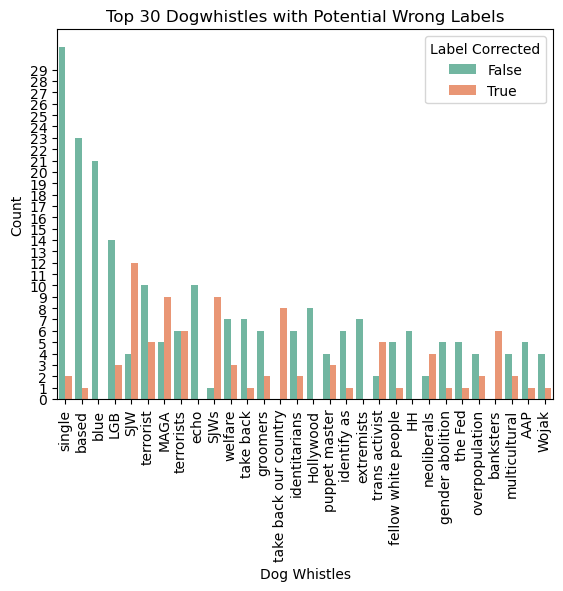

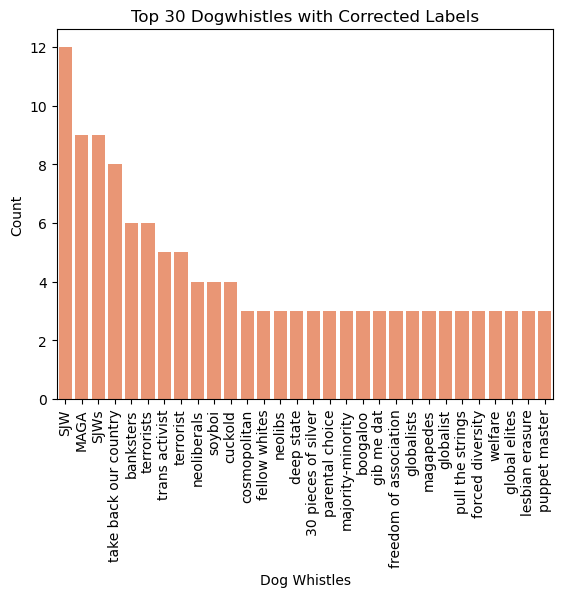

In [33]:

# get the split by updated column
sns.countplot(x='dog_whistles', data=reviewed_labels, hue='updated', order=reviewed_labels['dog_whistles'].value_counts().iloc[:30].index, palette='Set2')
# rotate x-axis labels
plt.xticks(rotation=90)
# y axis ticks only integers
plt.yticks(np.arange(0, 30, 1))
plt.xlabel('Dog Whistles')
# y axis label
plt.ylabel('Count')
# set legend title
plt.legend(title='Label Corrected')
plt.title('Top 30 Dogwhistles with Potential Wrong Labels')
# save the plot so it does not get cut off
plt.savefig('top_20_labels_with_potential_wrong_labels.png', bbox_inches='tight')
plt.show()

# most updated dog_whistles in reviewed_labels
updated_dog_whistles = reviewed_labels[reviewed_labels['updated'] == True]
sns.countplot(x='dog_whistles', data=updated_dog_whistles, order=updated_dog_whistles['dog_whistles'].value_counts().iloc[:30].index, color='#fc8d62')
# rotate x-axis labels
plt.xticks(rotation=90)
plt.xlabel('Dog Whistles')
plt.ylabel('Count')
plt.title('Top 30 Dogwhistles with Corrected Labels')
plt.show()

Out of the manual reviewed cases expectedly most had the keyword single in them. But here only a small portion was actually mislabeled. When looking at the dogwhistles that were manually changed the most SWJ MAGA and TBOC were the most common. Here There seems to be a bias towards there dogwhistles in the LLms used by Kruk et al.